# Loan Default Prediction 

In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Read dataset
df = pd.read_csv('Anonymize_Loan_Default_data.csv',)
print('Original shape:', df.shape)
df.head()

Original shape: (38480, 37)


,1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,...,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,repay_fail
0,2,2,2,0.0,0.0,0.0,36 months,0.00,0.00,< 1 year,...,1.0,0.000000,0.00,0.00,0.00,Jan-07,0.00,Jan-07,Jan-07,1
1,3,545583,703644,2500.0,2500.0,2500.0,36 months,13.98,85.42,4 years,...,10.0,3075.291779,3075.29,2500.00,575.29,Jul-13,90.85,Aug-13,Jun-16,0
2,4,532101,687836,5000.0,5000.0,5000.0,36 months,15.95,175.67,4 years,...,15.0,2948.760000,2948.76,1909.02,873.81,Nov-11,175.67,NaN,Mar-12,1
3,5,877788,1092507,7000.0,7000.0,7000.0,36 months,9.91,225.58,10+ years,...,20.0,8082.391880,8082.39,7000.00,1082.39,Mar-14,1550.27,NaN,Mar-14,0
4,6,875406,1089981,2000.0,2000.0,2000.0,36 months,5.42,60.32,10+ years,...,15.0,2161.663244,2161.66,2000.00,161.66,Feb-14,53.12,NaN,Jun-16,0


In [4]:
df.columns

Index(['1', 'id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'repay_fail'],
      dtype='object')

### Data Preprocessing

In [5]:
df = df.copy()
# Drop columns with >50% missing
th = 0.5
missing_frac = df.isna().mean()
cols_drop_missing = missing_frac[missing_frac>th].index.tolist()

# Identify post-payment columns by keywords
leak_keywords = ['total_pymnt','total_rec','last_pymnt','next_pymnt','recoveries','collection','chargeoff','out_prncp','settlement','debt_settlement','last_credit_pull']
leak_cols = [c for c in df.columns if any(k in c.lower() for k in leak_keywords)]

# Combine and protect a few important columns
drop_candidates = set(cols_drop_missing + leak_cols)
for keep in ['issue_d','earliest_cr_line','repay_fail','loan_status','id','member_id']:
    drop_candidates.discard(keep)

print('Dropping', len(drop_candidates),'columns (examples):', list(drop_candidates)[:10])

df.drop(columns=[c for c in drop_candidates if c in df.columns], inplace=True, errors='ignore')

Dropping 9 columns (examples): ['mths_since_last_delinq', 'total_pymnt_inv', 'last_pymnt_amnt', 'total_rec_prncp', 'last_pymnt_d', 'last_credit_pull_d', 'total_pymnt', 'next_pymnt_d', 'total_rec_int']


In [6]:
df.columns

Index(['1', 'id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'repay_fail'],
      dtype='object')

In [7]:
# Convert earliest_cr_line and issue_d with correct format
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%y', errors='coerce')
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%y', errors='coerce')

# Create credit age in years
df['credit_age_years'] = df['issue_d'].dt.year - df['earliest_cr_line'].dt.year

# Replace negatives with NaN
df.loc[df['credit_age_years'] < 0, 'credit_age_years'] = np.nan

df['credit_age_years'].head()


0     NaN
1     5.0
2    16.0
3    13.0
4    36.0
Name: credit_age_years, dtype: float64

In [8]:
# Convert 'term' from '36 months' → 36, '60 months' → 60
if 'term' in df.columns:
    df['term'] = (
        df['term']
        .astype(str)
        .str.lower()
        .str.replace('months', '')
        .str.replace('month', '')
        .str.strip()
    )
    df['term'] = pd.to_numeric(df['term'], errors='coerce')


In [9]:
df.columns

Index(['1', 'id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'repay_fail',
       'credit_age_years'],
      dtype='object')

In [10]:
# emp_length -> numeric
if 'emp_length' in df.columns:
    def parse_emp_length(x):
        if pd.isna(x): return np.nan
        s = str(x).lower().replace('years','').replace('year','').replace('+','').strip()
        if '<' in s: return 0.0
        try:
            return float(s)
        except:
            return np.nan
    df['emp_length_years'] = df['emp_length'].apply(parse_emp_length)
    df.drop(columns=['emp_length'], inplace=True, errors='ignore')

# percent -> numeric
for col in ['int_rate','revol_util']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace('%','').str.strip(), errors='coerce')

In [11]:
# loan_to_income
if 'loan_amnt' in df.columns and 'annual_inc' in df.columns:
    df['loan_to_income'] = df['loan_amnt'] / df['annual_inc'].replace(0, np.nan)

# zip prefix
if 'zip_code' in df.columns:
    df['zip_code_prefix'] = df['zip_code'].astype(str).str[:3]
    df.drop(columns=['zip_code'], inplace=True, errors='ignore')

In [12]:
# Drop constant columns
drop_const = [c for c in df.columns if df[c].nunique(dropna=True)<=1]
if drop_const:
    df.drop(columns=drop_const, inplace=True, errors='ignore')

# Ensure target exists; drop rows with missing target
if 'repay_fail' in df.columns:
    df = df[~df['repay_fail'].isna()].copy()

In [13]:
# Numeric->median, categorical->mode
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
num_cols = [c for c in num_cols if c!='repay_fail']
for c in num_cols:
    df[c].fillna(df[c].median(), inplace=True)
for c in cat_cols:
    try:
        mode = df[c].mode(dropna=True)
        df[c].fillna(mode[0] if len(mode)>0 else 'Missing', inplace=True)
    except:
        df[c].fillna('Missing', inplace=True)

In [14]:
# Save cleaned CSV
print('Cleaned shape:', df.shape)
df.to_csv('cleaned_data.csv', index=False)
print('Cleaned CSV saved')

# show columns and first rows
print('Columns:', df.columns.tolist()[:40])
df.head()

Cleaned shape: (38480, 30)
Cleaned CSV saved
Columns: ['1', 'id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'repay_fail', 'credit_age_years', 'emp_length_years', 'loan_to_income', 'zip_code_prefix']


,1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,home_ownership,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,repay_fail,credit_age_years,emp_length_years,loan_to_income,zip_code_prefix
0,2,2,2,0.0,0.0,0.0,36,0.00,0.00,RENT,...,0.0,0.0,0.0,49.6,1.0,1,12.0,0.0,0.163043,000
1,3,545583,703644,2500.0,2500.0,2500.0,36,13.98,85.42,RENT,...,7.0,0.0,981.0,21.3,10.0,0,5.0,4.0,0.124975,487
2,4,532101,687836,5000.0,5000.0,5000.0,36,15.95,175.67,RENT,...,7.0,0.0,18773.0,99.9,15.0,1,16.0,4.0,0.084746,115
3,5,877788,1092507,7000.0,7000.0,7000.0,36,9.91,225.58,MORTGAGE,...,7.0,0.0,3269.0,47.2,20.0,0,13.0,10.0,0.130121,751
4,6,875406,1089981,2000.0,2000.0,2000.0,36,5.42,60.32,RENT,...,7.0,0.0,0.0,0.0,15.0,0,36.0,10.0,0.066667,112


In [15]:
# Read cleaned CSV 
clean = pd.read_csv('cleaned_data.csv', low_memory=False)
print('Loaded cleaned file, shape:', clean.shape)
clean.head()


Loaded cleaned file, shape: (38480, 30)


,1,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,home_ownership,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,repay_fail,credit_age_years,emp_length_years,loan_to_income,zip_code_prefix
0,2,2,2,0.0,0.0,0.0,36,0.00,0.00,RENT,...,0.0,0.0,0.0,49.6,1.0,1,12.0,0.0,0.163043,0
1,3,545583,703644,2500.0,2500.0,2500.0,36,13.98,85.42,RENT,...,7.0,0.0,981.0,21.3,10.0,0,5.0,4.0,0.124975,487
2,4,532101,687836,5000.0,5000.0,5000.0,36,15.95,175.67,RENT,...,7.0,0.0,18773.0,99.9,15.0,1,16.0,4.0,0.084746,115
3,5,877788,1092507,7000.0,7000.0,7000.0,36,9.91,225.58,MORTGAGE,...,7.0,0.0,3269.0,47.2,20.0,0,13.0,10.0,0.130121,751
4,6,875406,1089981,2000.0,2000.0,2000.0,36,5.42,60.32,RENT,...,7.0,0.0,0.0,0.0,15.0,0,36.0,10.0,0.066667,112


### Outlier Detection

In [16]:
# Outlier detection: IQR per numeric column
num_cols = clean.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c!='repay_fail']
for c in num_cols[:10]:
    q1 = clean[c].quantile(0.25); q3 = clean[c].quantile(0.75); iqr = q3-q1
    low = q1-1.5*iqr; high=q3+1.5*iqr
    print(c, 'outliers:', ((clean[c]<low)|(clean[c]>high)).sum())

# IsolationForest flag (best-effort)
try:
    from sklearn.ensemble import IsolationForest
    iso = IsolationForest(contamination=0.01, random_state=42)
    iso_cols = [c for c in num_cols if clean[c].nunique()>1]
    clean['outlier_iso'] = (iso.fit_predict(clean[iso_cols].fillna(0).values) == -1).astype(int)
    print('IsolationForest outliers flagged:', clean['outlier_iso'].sum())
except Exception as e:
    print('IsolationForest skipped:', e)

clean['outlier_iqr_count'] = 0
for c in num_cols:
    q1 = clean[c].quantile(0.25); q3 = clean[c].quantile(0.75); iqr = q3-q1
    low = q1-1.5*iqr; high=q3+1.5*iqr
    clean['outlier_iqr_count'] += ((clean[c]<low)|(clean[c]>high)).astype(int)

print('Sample outlier counts (head):')
clean[['outlier_iso','outlier_iqr_count']].head()


1 outliers: 0
id outliers: 2
member_id outliers: 2
loan_amnt outliers: 1103
funded_amnt outliers: 931
funded_amnt_inv outliers: 1043
term outliers: 0
int_rate outliers: 89
installment outliers: 1232
annual_inc outliers: 1844
IsolationForest outliers flagged: 385
Sample outlier counts (head):


,outlier_iso,outlier_iqr_count
0,0,3
1,0,0
2,0,0
3,0,1
4,0,1


### EDA

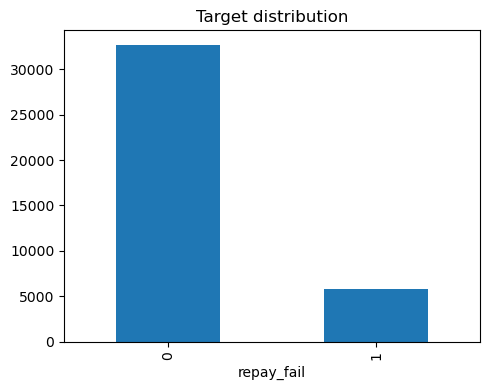

In [42]:
plt.figure(figsize=(5,4))
clean['repay_fail'].value_counts().plot(kind='bar')
plt.title('Target distribution')

plt.tight_layout()
plt.savefig('images/target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


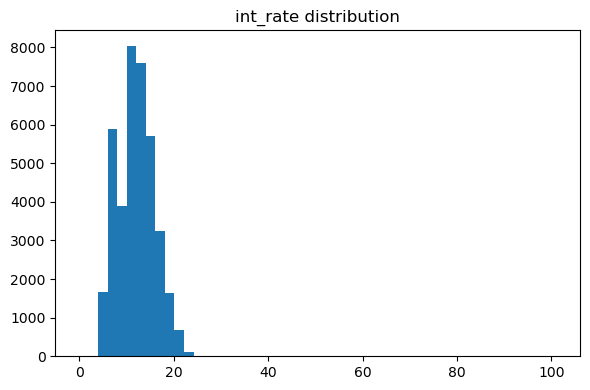

In [43]:
plt.figure(figsize=(6,4))
plt.hist(clean['int_rate'].dropna(), bins=50)
plt.title('int_rate distribution')

plt.tight_layout()
plt.savefig('images/int_rate_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

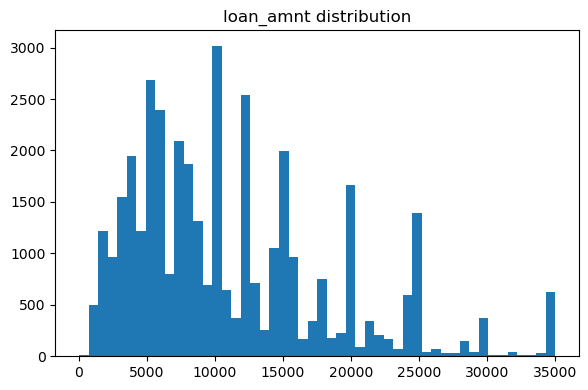

In [44]:
plt.figure(figsize=(6,4))
plt.hist(clean['loan_amnt'].dropna(), bins=50)
plt.title('loan_amnt distribution')

plt.tight_layout()
plt.savefig('images/loan_amnt_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

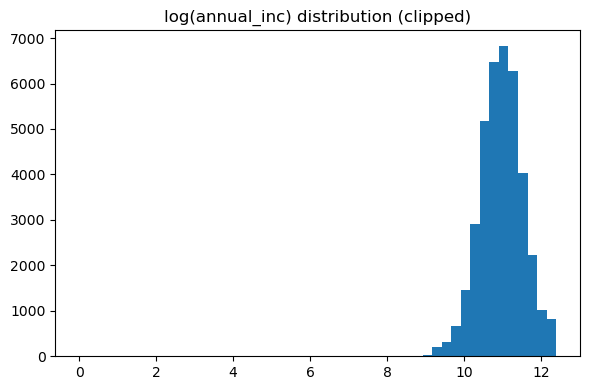

In [45]:
plt.figure(figsize=(6,4))
plt.hist(np.log1p(clean['annual_inc'].clip(upper=clean['annual_inc'].quantile(0.99)).fillna(0)), bins=50)
plt.title('log(annual_inc) distribution (clipped)')

plt.tight_layout()
plt.savefig('images/log_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

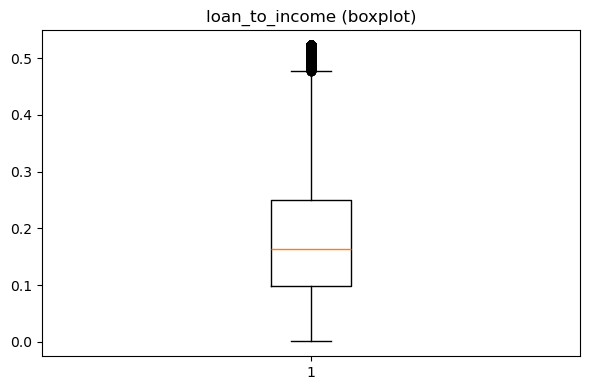

In [46]:
plt.figure(figsize=(6,4))
plt.boxplot(clean['loan_to_income'].dropna().clip(upper=clean['loan_to_income'].quantile(0.99)))
plt.title('loan_to_income (boxplot)')

plt.tight_layout()
plt.savefig('images/loan_to_income.png', dpi=300, bbox_inches='tight')
plt.show()


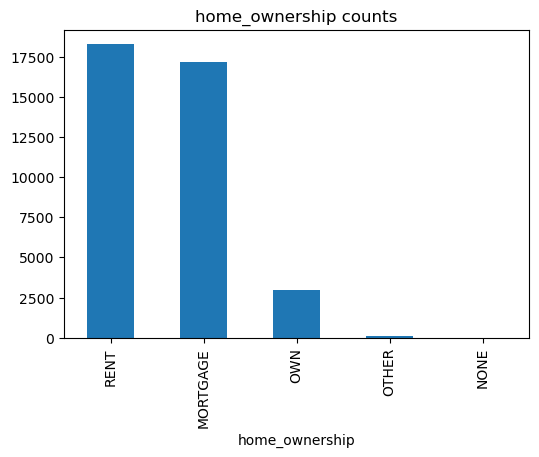

In [22]:
plt.figure(figsize=(6,4))
clean['home_ownership'].value_counts().plot(kind='bar')
plt.title('home_ownership counts')
plt.show()


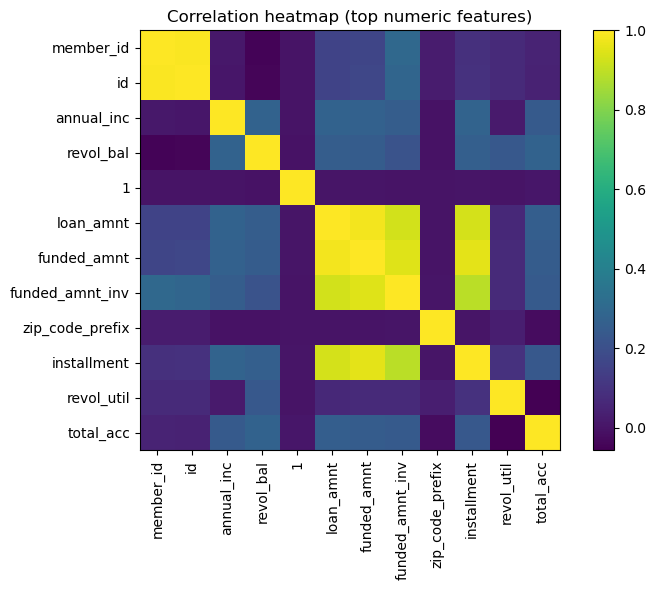

In [47]:
num = clean.select_dtypes(include=[np.number]).drop(columns=['repay_fail'], errors='ignore')
vars = num.var().sort_values(ascending=False).index.tolist()[:12]
plt.figure(figsize=(8,6))
plt.imshow(clean[vars].corr(), interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(vars)), vars, rotation=90)
plt.yticks(range(len(vars)), vars)
plt.title('Correlation heatmap (top numeric features)')

plt.tight_layout()
plt.savefig('images/Correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


In [24]:
clean.columns

Index(['1', 'id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'repay_fail', 'credit_age_years', 'emp_length_years',
       'loan_to_income', 'zip_code_prefix', 'outlier_iso',
       'outlier_iqr_count'],
      dtype='object')

In [25]:
# Feature generation (examples already applied: credit_age_years, emp_length_years, loan_to_income)
feats = ['credit_age_years','emp_length_years','loan_to_income']
print('Engineered features present:', [f for f in feats if f in clean.columns])
clean[feats].describe()


Engineered features present: ['credit_age_years', 'emp_length_years', 'loan_to_income']


,credit_age_years,emp_length_years,loan_to_income
count,38480.000000,38480.000000,38480.000000
mean,13.571830,4.898389,0.186452
std,6.697989,3.521589,0.116359
min,0.000000,0.000000,0.000833
25%,9.000000,2.000000,0.098190
50%,12.000000,4.000000,0.163043
75%,17.000000,9.000000,0.250000
max,42.000000,10.000000,1.337500


In [26]:
clean.columns

Index(['1', 'id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'repay_fail', 'credit_age_years', 'emp_length_years',
       'loan_to_income', 'zip_code_prefix', 'outlier_iso',
       'outlier_iqr_count'],
      dtype='object')

In [27]:
model_df = clean.copy()
# Drop identifiers
for c in ['id','member_id']:
    if c in model_df.columns: model_df.drop(columns=[c], inplace=True, errors='ignore')

y = model_df['repay_fail']
X = model_df.drop(columns=['repay_fail','issue_d'], errors='ignore')

# One-hot small categorical columns (<=30)
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
low_card = [c for c in cat_cols if X[c].nunique()<=30]
X = pd.get_dummies(X, columns=low_card, drop_first=True)

# Fill remaining NaNs
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
X[num_cols] = X[num_cols].fillna(X[num_cols].median())

print('Prepared X shape:', X.shape)


Prepared X shape: (38480, 51)


### Test Train Split

In [28]:
from sklearn.preprocessing import StandardScaler

if 'issue_d' in model_df.columns and model_df['issue_d'].notnull().any():
    df_sorted = model_df.sort_values('issue_d')
    split_idx = int(len(df_sorted)*0.7)
    train_df = df_sorted.iloc[:split_idx]
    test_df = df_sorted.iloc[split_idx:]
    
    X_train = train_df.drop(columns=['repay_fail','issue_d'], errors='ignore')
    y_train = train_df['repay_fail']

    X_test = test_df.drop(columns=['repay_fail','issue_d'], errors='ignore')
    y_test = test_df['repay_fail']

    X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

    num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    scaler = StandardScaler()
    X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_test[num_cols] = scaler.transform(X_test[num_cols])

else:
    from sklearn.model_selection import train_test_split
    X = model_df.drop(columns=['repay_fail','issue_d'], errors='ignore')
    y = model_df['repay_fail']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    scaler = StandardScaler()
    X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_test[num_cols] = scaler.transform(X_test[num_cols])


In [29]:
# Identify categorical columns
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# One-hot encode
X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)

# Align columns
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)


### Logistic Regression

Logistic Regression Accuracy: 0.9984

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9770
           1       0.99      1.00      0.99      1774

    accuracy                           1.00     11544
   macro avg       0.99      1.00      1.00     11544
weighted avg       1.00      1.00      1.00     11544



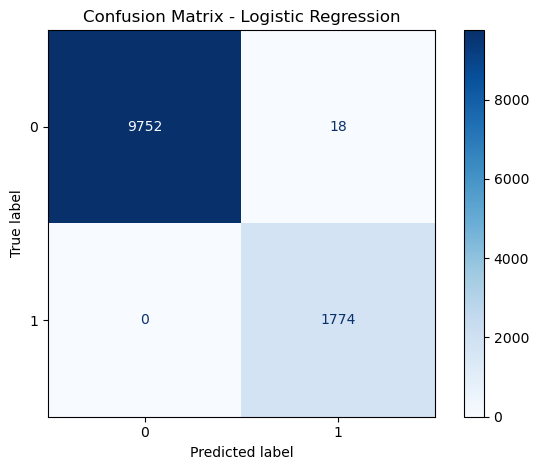

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Train Logistic Regression
log_reg = LogisticRegression(class_weight='balanced', max_iter=50000)
log_reg.fit(X_train, y_train)

# Predictions
y_pred_lr = log_reg.predict(X_test)

# Accuracy
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr:.4f}")

# Classification Report
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_lr))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")

plt.tight_layout()
plt.savefig('images/Confusion_Matrix_Logistic_Regression.png', dpi=300, bbox_inches='tight')
plt.show()

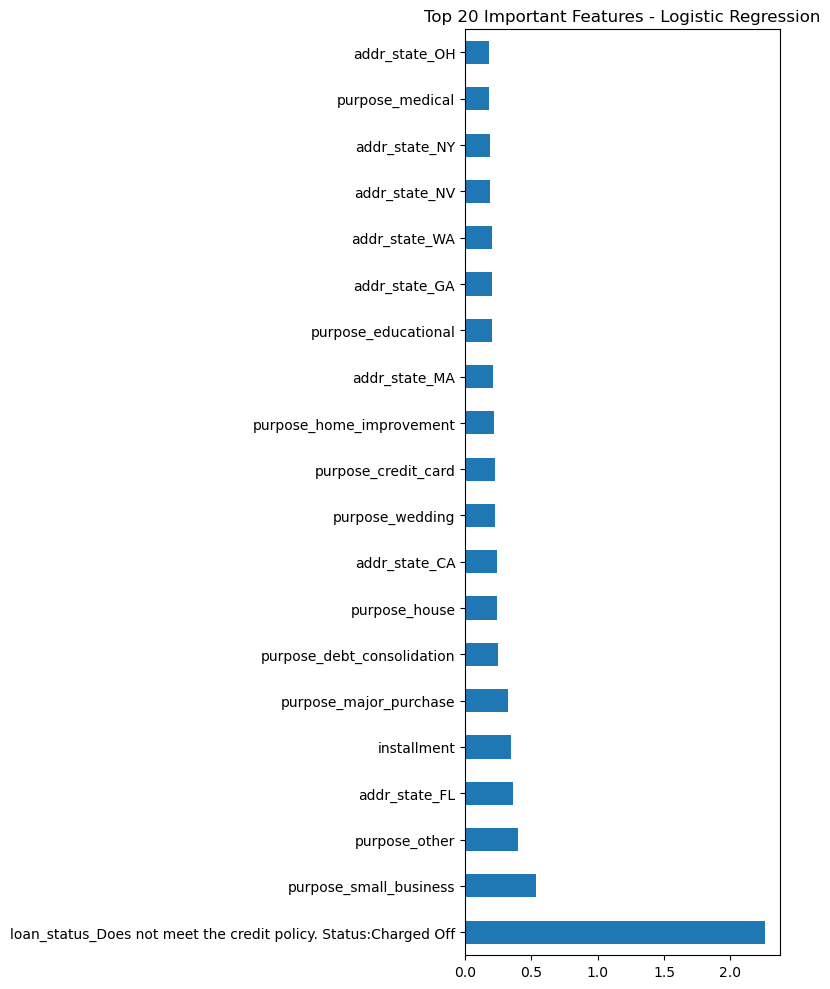

In [49]:
# Logistic Regression Feature Importance
importance_lr = pd.Series(log_reg.coef_[0], index=X_train.columns)
importance_lr = importance_lr.sort_values(ascending=False)

plt.figure(figsize=(8,10))
importance_lr.head(20).plot(kind='barh')
plt.title("Top 20 Important Features - Logistic Regression")

plt.tight_layout()
plt.savefig('images/Feature_importance_Logistic_Regression.png', dpi=300, bbox_inches='tight')
plt.show()

### Random Forest

Random Forest Accuracy: 0.9699

Classification Report (Random Forest):

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      9770
           1       0.84      0.99      0.91      1774

    accuracy                           0.97     11544
   macro avg       0.92      0.98      0.95     11544
weighted avg       0.97      0.97      0.97     11544



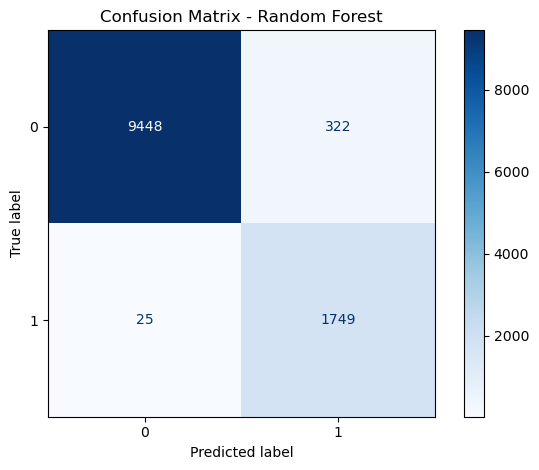

In [50]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)

rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)

# Accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")

# Classification Report
print("\nClassification Report (Random Forest):\n")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf)

disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Random Forest")

plt.tight_layout()
plt.savefig('images/Confusion_Matrix_Random_Forest.png', dpi=300, bbox_inches='tight')
plt.show()

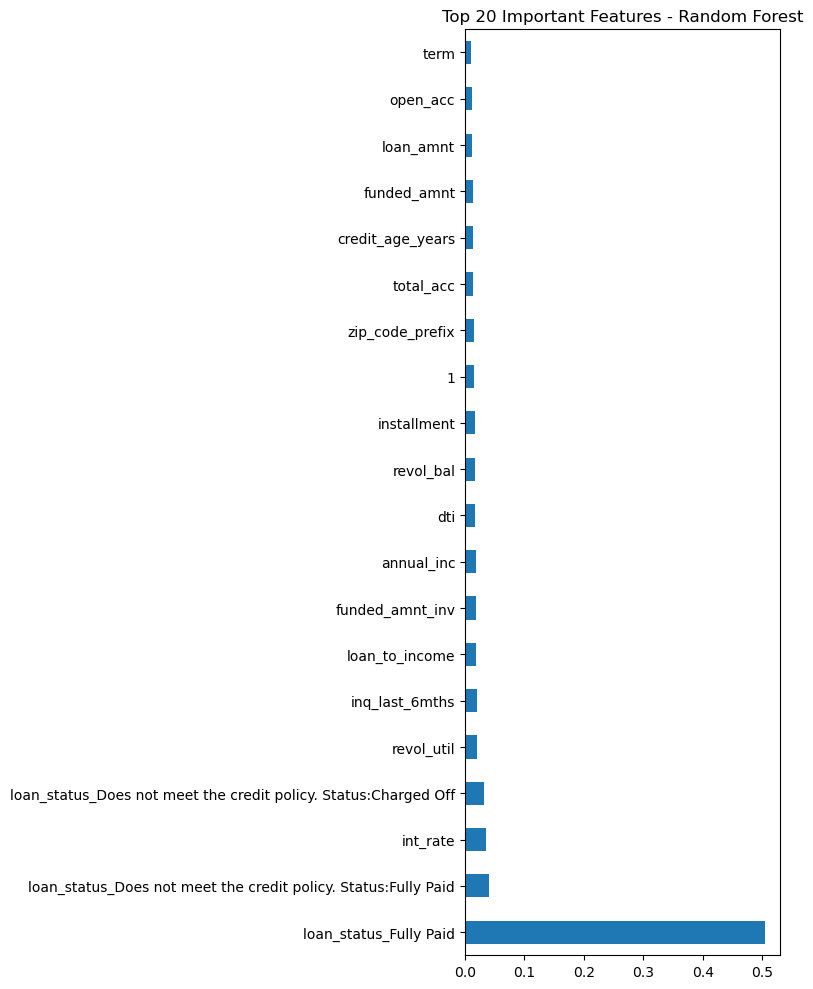

In [51]:
# Random Forest Feature Importance
importance_rf = pd.Series(rf.feature_importances_, index=X_train.columns)
importance_rf = importance_rf.sort_values(ascending=False)

plt.figure(figsize=(8,10))
importance_rf.head(20).plot(kind='barh')
plt.title("Top 20 Important Features - Random Forest")

plt.tight_layout()
plt.savefig('images/Feature_importance_Random_Forest.png', dpi=300, bbox_inches='tight')
plt.show()

### Linear SVM Classifier

Linear SVM Accuracy: 1.0000

Classification Report (Linear SVM):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9770
           1       1.00      1.00      1.00      1774

    accuracy                           1.00     11544
   macro avg       1.00      1.00      1.00     11544
weighted avg       1.00      1.00      1.00     11544



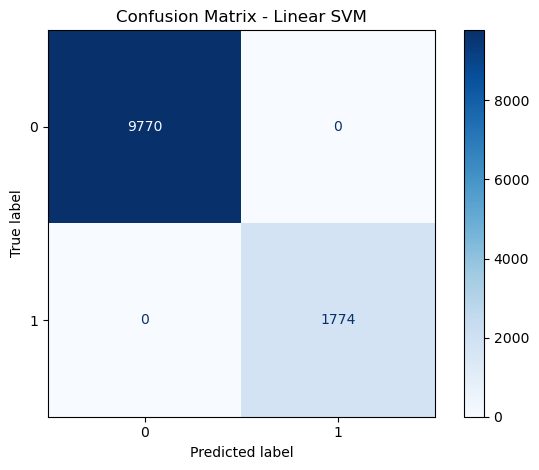

In [52]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Train Linear SVM Classifier
svm_classifier = LinearSVC(class_weight='balanced', max_iter=50000)
svm_classifier.fit(X_train, y_train)

# Predict
y_pred_svm = svm_classifier.predict(X_test)

# Accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Linear SVM Accuracy: {accuracy_svm:.4f}")

# Report
print("\nClassification Report (Linear SVM):")
print(classification_report(y_test, y_pred_svm))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Linear SVM")

plt.tight_layout()
plt.savefig('images/Confusion_Matrix_Linear_SVM.png', dpi=300, bbox_inches='tight')
plt.show()

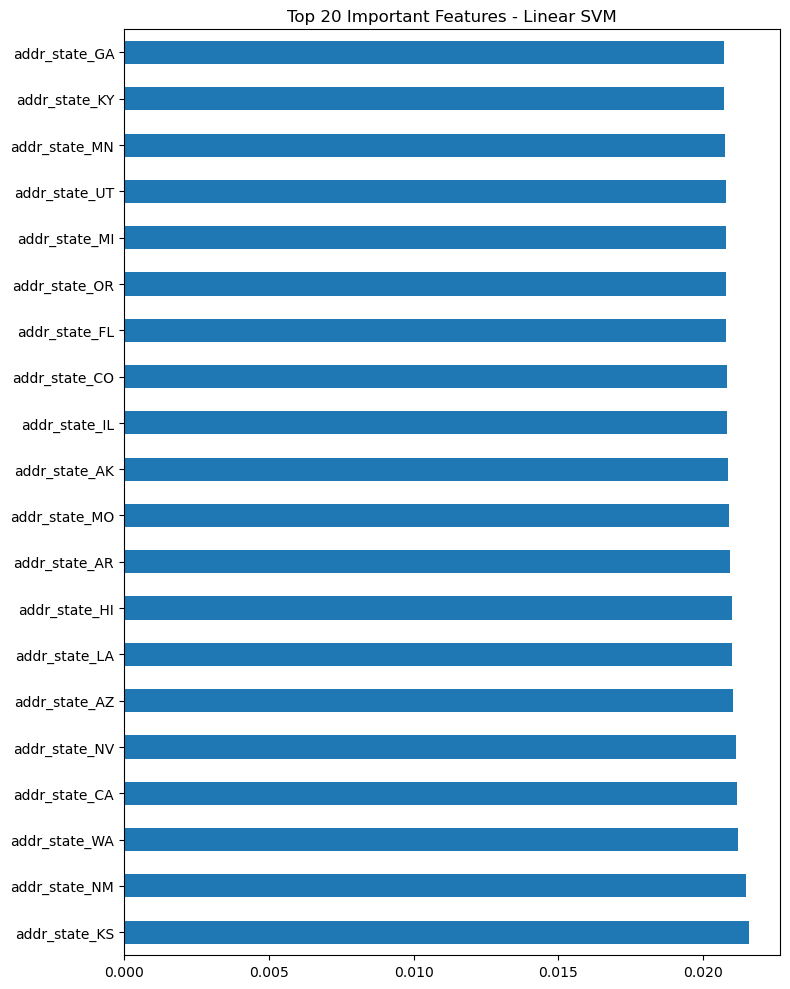

In [53]:
# Linear SVM Feature Importance (Correct)
importance_svm = pd.Series(svm_classifier.coef_[0], index=X_train.columns)
importance_svm = importance_svm.sort_values(ascending=False)

plt.figure(figsize=(8,10))
importance_svm.head(20).plot(kind='barh')
plt.title("Top 20 Important Features - Linear SVM")

plt.tight_layout()
plt.savefig('images/Feature_importance_Linear_SVM.png', dpi=300, bbox_inches='tight')
plt.show()

### Model Comparison

In [36]:
results = pd.DataFrame({
    'Model': ['Logistic Regression','Random Forest','SVM'],
    'Accuracy': [accuracy_lr, accuracy_rf, accuracy_svm]
})

results


,Model,Accuracy
0,Logistic Regression,0.998441
1,Random Forest,0.969941
2,SVM,1.000000
